# Table of Contents

* [Hard Coded NN](#chapter1)

* [Autograd](#chapter2)

* [NN](#chapter3)
    * [Set Up as Class](#section_3_1)
    * [Optimiser](#section_3_2)
    * [Working on GPU](#section_3_3)

* [Dataloader](#chapter4)

* [Ignite](#chapter5)

* [Tensorboard](#chapter6)
    * [Model saving and loading](#section_6_1)
    
* [MNIST Data](#chapter7)

* [Optimisation](#chapter8)

This is step by step of building up a NN using PyTorch.

**Some cool PyTorch extras**

*optimisers*              
- torch.optim.SGD
- torch.optim.RMSProp
- torch.optim.Adam

*learning rate scheduler*
- torch.optim.lr_scheduler.StepLR

*learning rate finder*    
- `lr_finder = LRFinder(model, optimiser, criterion)`
- `lr_finder.range_test(trainloader,start_lr, end_lr, num iter)`
- `lr_finder.plot()`
- `lr_finder.reset()`

*regularisation*
- add weight_decay to optimiser

*dropout*
- torch.nn.Dropout
    - `model.train` to train
    - `model.eval` to evaluate

*batch normalisation*
- torch.nn.BatchNorm1d
- torch.nn.BatchNorm2d

*saving network*
- `torch.save(model.state_dict(),<PATH>)`
    
*loading network*
- `model = ModelClass(*args, **kwargs)`
- `model.load_state_dict(torch.load(<PATH>))`
- `model.eval()`

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch

C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
plt.style.use('dark_background')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

# 1. Hard Coded NN<a class="anchor" id="chapter1"></a>

In [3]:
import sys
sys.path.append(os.path.join(os.path.abspath('.'), 'data'))
import deep_learning

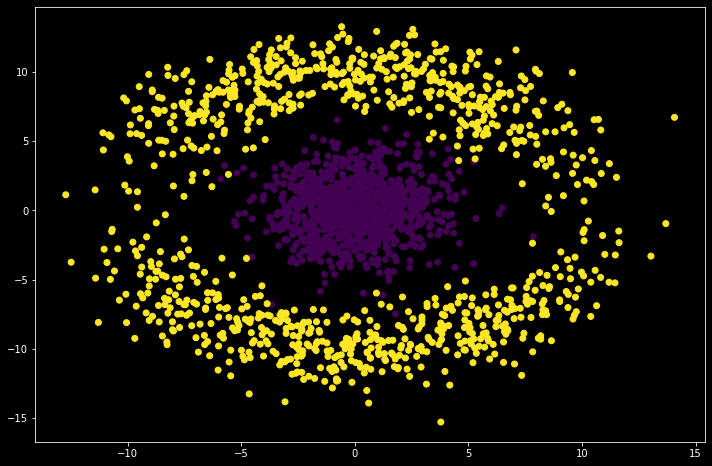

In [4]:
# setup data

N = 1000
df_train = deep_learning.ring.get_data(N=N)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(
    df_train['x1'], 
    df_train['x2'], 
    c=df_train['y']
)

In [5]:
# set up tensor objects

X = torch.tensor(
    df_train[['x1','x2']].values, 
    dtype=torch.float32
)

y = torch.tensor(
    df_train[['y']].values, 
    dtype=torch.float32
)

In [6]:
%%time

# fit NN

n_inputs = 2 # x1, x2
n_outputs = 1 # y
hidden_units = 4 # we can pick

W1 = torch.tensor(
    np.random.randn(n_inputs, hidden_units)/100, 
    dtype=torch.float32
) # first layer

b1 = torch.zeros(
    size=(1, hidden_units)
) # bias

W2 = torch.tensor(
    np.random.randn(hidden_units, n_outputs)/100, 
    dtype=torch.float32
) # second layer

b2 = torch.zeros(
    size=(1, n_outputs)
) # bias

epochs = 5000
lr = 0.001

mses = []

for epoch in range(epochs):
    
    ### forward prop (matrix multiplication)
    
    ## layer 1
    Z1 = torch.matmul(X,W1) + b1
    
    # implement ReLU
    A1 = Z1.clamp(min=0)
    
    ## layer 2
    Z2 = torch.matmul(A1,W2) + b2
    
    # implement identity
    A2 = Z2
    
    # loss
    mse = torch.mean((A2-y)**2)
    mses.append(mse)    
    
    if epoch % 200 == 0:
    
        print(f'Epoch:\t{epoch}\tMSE:\t{round(mse.item(), 2)}')
    
    ### backward prop (multiple differentiation)
    
    # loss
    dA2 = 2*(A2 - y)
    
    ## layer 2
    dZ2 = dA2
    dW2 = torch.matmul(A1.T, dZ2)/N
    db2 = torch.mean(dZ2, axis=0, keepdim=True)
    dA1 = torch.matmul(dZ2, W2.T)
    
    ## layer 1
    dZ1 = torch.where(Z1>0, dA1, torch.zeros_like(dA1))
    dW1 = torch.matmul(X.T, dZ1)/N
    db1 = torch.mean(dZ1, axis=0, keepdim=True)
    dA0 = torch.matmul(dZ1, W1.T)
    
    ### update parameters
    
    W1 = W1 - lr*dW1
    b1 = b1 - lr*db1
    W2 = W2 - lr*dW2
    b2 = b2 - lr*db2

Epoch:	0	MSE:	0.5
Epoch:	200	MSE:	0.36
Epoch:	400	MSE:	0.27
Epoch:	600	MSE:	0.21
Epoch:	800	MSE:	0.2
Epoch:	1000	MSE:	0.19
Epoch:	1200	MSE:	0.17
Epoch:	1400	MSE:	0.15
Epoch:	1600	MSE:	0.13
Epoch:	1800	MSE:	0.11
Epoch:	2000	MSE:	0.1
Epoch:	2200	MSE:	0.09
Epoch:	2400	MSE:	0.09
Epoch:	2600	MSE:	0.08
Epoch:	2800	MSE:	0.08
Epoch:	3000	MSE:	0.08
Epoch:	3200	MSE:	0.08
Epoch:	3400	MSE:	0.07
Epoch:	3600	MSE:	0.07
Epoch:	3800	MSE:	0.07
Epoch:	4000	MSE:	0.07
Epoch:	4200	MSE:	0.07
Epoch:	4400	MSE:	0.07
Epoch:	4600	MSE:	0.07
Epoch:	4800	MSE:	0.07
CPU times: total: 20.2 s
Wall time: 5.15 s


Text(0.5, 1.0, 'MSE Evloution by Epoch')

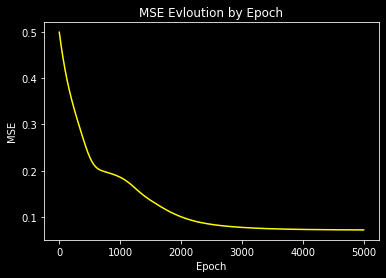

In [7]:
fig, ax = plt.subplots()
ax.plot(
    list(range(epochs)),
    mses,
    c='yellow'
)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE Evloution by Epoch')

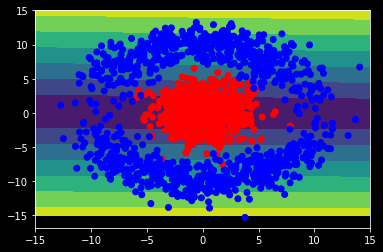

In [8]:
# decison boundary plot

X1, X2 = np.meshgrid(
    np.linspace(-15,15,num=50),
    np.linspace(-15,15,num=50)
)

X_mesh = torch.tensor(
    np.c_[X1.ravel(),X2.ravel()], 
    dtype=torch.float32
)
A1 = (
    torch.matmul(X_mesh, W1) + b1
).clamp(min=0)

A2 = torch.matmul(A1, W2) + b2

A2 = A2.squeeze().reshape(X1.shape).numpy()

fig, ax = plt.subplots()
ax.contourf(X1, X2, A2)
ax.scatter(
    df_train['x1'], 
    df_train['x2'], 
    c=df_train['y'].map(
        {0:'red', 1:'blue'}
    )
)

# 2. Autograd<a class="anchor" id="chapter2"></a>

In [9]:
import sys
sys.path.append(os.path.join(os.path.abspath('.'), 'data'))
import deep_learning

In [10]:
# set up tensors

a = torch.tensor(
    [1.], requires_grad=True
)
b = torch.tensor(
    [2.], requires_grad=True
)
c = torch.tensor(
    [3.], requires_grad=True
)

J = 3 * (a * b + c)

J.backward()

print('---------------------------')
print('dJ/da:', a.grad)
print('---------------------------')
print('dJ/db:', b.grad)
print('---------------------------')
print('dJ/dc:', c.grad)
print('---------------------------')

---------------------------
dJ/da: tensor([6.])
---------------------------
dJ/db: tensor([3.])
---------------------------
dJ/dc: tensor([3.])
---------------------------


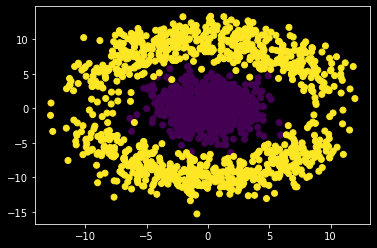

In [11]:
# set up data to utilise autograd

N = 1000
df_train = deep_learning.ring.get_data(N=N)

fig, ax = plt.subplots()
ax.scatter(
    df_train['x1'], 
    df_train['x2'], 
    c=df_train['y']
)

In [12]:
X = torch.tensor(
    df_train[['x1','x2']].values, 
    dtype=torch.float32
)
y = torch.tensor(
    df_train[['y']].values, 
    dtype=torch.float32
)

In [13]:
%%time

n_inputs = 2
n_outputs = 1
hidden_units = 4

W1 = torch.tensor(
    np.random.randn(n_inputs, hidden_units)/100, 
    dtype=torch.float32, 
    requires_grad=True
)

b1 = torch.zeros(
    size=(1, hidden_units), 
    requires_grad=True
)

W2 = torch.tensor(
    np.random.randn(hidden_units, n_outputs)/100, 
    dtype=torch.float32,
    requires_grad=True
)

b2 = torch.zeros(
    size=(1, n_outputs), 
    requires_grad=True
)

epochs = 20000
lr = 1e-2

mses = []

for epoch in range(epochs):
    
    ### forward prop
    
    ## layer 1
    Z1 = torch.matmul(X, W1) + b1
    
    # implement ReLU
    A1 = Z1.clamp(min=0)
    
    ## layer 2
    Z2 = torch.matmul(A1, W2) + b2
    
    # implement identity
    A2 = Z2
    
    # loss
    mse = torch.mean((A2 - y) ** 2)
    mses.append(mse)    
    
    if epoch % 1000 == 0:
    
        print(f'Epoch:\t{epoch}\tMSE:\t{round(mse.item(), 2)}')

    # find gradients
    mse.backward()
    
    
    with torch.no_grad():
    ### update parameters
        
        W1 -= lr * W1.grad
        b1 -= lr * b1.grad
        W2 -= lr * W2.grad
        b2 -= lr * b2.grad
        
        # reset the gradients
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()

Epoch:	0	MSE:	0.5
Epoch:	1000	MSE:	0.07
Epoch:	2000	MSE:	0.03
Epoch:	3000	MSE:	0.03
Epoch:	4000	MSE:	0.03
Epoch:	5000	MSE:	0.03
Epoch:	6000	MSE:	0.03
Epoch:	7000	MSE:	0.03
Epoch:	8000	MSE:	0.03
Epoch:	9000	MSE:	0.03
Epoch:	10000	MSE:	0.03
Epoch:	11000	MSE:	0.03
Epoch:	12000	MSE:	0.03
Epoch:	13000	MSE:	0.03
Epoch:	14000	MSE:	0.03
Epoch:	15000	MSE:	0.03
Epoch:	16000	MSE:	0.03
Epoch:	17000	MSE:	0.03
Epoch:	18000	MSE:	0.03
Epoch:	19000	MSE:	0.03
CPU times: total: 1min 33s
Wall time: 23.5 s


Text(0.5, 1.0, 'MSE Evloution by Epoch')

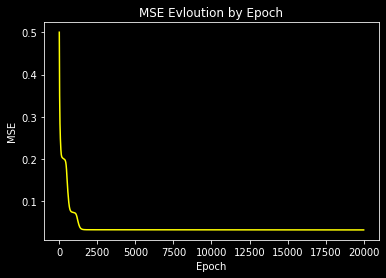

In [14]:
fig, ax = plt.subplots()
ax.plot(
    list(range(epochs)),
    [i.detach() for i in mses],
    c='yellow'
)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE Evloution by Epoch')

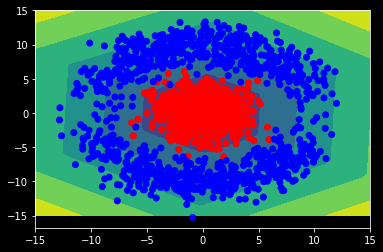

In [15]:
# decison boundary plot

X1, X2 = np.meshgrid(
    np.linspace(-15,15,num=50),
    np.linspace(-15,15,num=50)
)

X_mesh = torch.tensor(
    np.c_[X1.ravel(),X2.ravel()], 
    dtype=torch.float32
)
A1 = (
    torch.matmul(X_mesh, W1) + b1
).clamp(min=0)

A2 = torch.matmul(A1, W2) + b2

A2 = A2.squeeze().reshape(X1.shape).detach().numpy()

fig, ax = plt.subplots()
ax.contourf(X1, X2, A2)
ax.scatter(
    df_train['x1'], 
    df_train['x2'], 
    c=df_train['y'].map(
        {0:'red', 1:'blue'}
    )
)

# 3. NN<a class="anchor" id="chapter3"></a>

In [16]:
import sys
sys.path.append(os.path.join(os.path.abspath('.'), 'data'))
import deep_learning
import torch.nn as nn

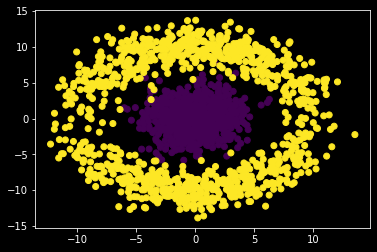

In [17]:
# set up data

N = 1000
df_train = deep_learning.ring.get_data(N=N)

fig, ax = plt.subplots()
ax.scatter(
    df_train['x1'], 
    df_train['x2'], 
    c=df_train['y']
)

In [18]:
%%time

# fitting the NN

n_inputs = 2
hidden_units = 4
n_outputs = 1

epochs = 20000
lr = 1e-2

model = nn.Sequential(
    nn.Linear(n_inputs, hidden_units),
    nn.ReLU(),
    nn.Linear(hidden_units, n_outputs)
)

mses = []

for epoch in range(epochs):

    A2 = model(X)
    
    # loss
    mse = torch.mean((A2-y)**2)
    mses.append(mse)
    if (epoch % 1000) == 0:
        print(f'Epoch:\t{epoch}\tMSE:\t{round(mse.item(), 2)}')
        
    ### backward prop    
    model.zero_grad()    
            
    # find gradients
    mse.backward()
    
    
    with torch.no_grad():
    ### update parameters
    
        for param in model.parameters():
            param -= lr*param.grad

Epoch:	0	MSE:	2.44
Epoch:	1000	MSE:	0.03
Epoch:	2000	MSE:	0.03
Epoch:	3000	MSE:	0.03
Epoch:	4000	MSE:	0.03
Epoch:	5000	MSE:	0.03
Epoch:	6000	MSE:	0.03
Epoch:	7000	MSE:	0.03
Epoch:	8000	MSE:	0.03
Epoch:	9000	MSE:	0.03
Epoch:	10000	MSE:	0.03
Epoch:	11000	MSE:	0.03
Epoch:	12000	MSE:	0.03
Epoch:	13000	MSE:	0.03
Epoch:	14000	MSE:	0.03
Epoch:	15000	MSE:	0.03
Epoch:	16000	MSE:	0.03
Epoch:	17000	MSE:	0.03
Epoch:	18000	MSE:	0.03
Epoch:	19000	MSE:	0.03
CPU times: total: 2min
Wall time: 31.1 s


In [19]:
%%time

# change hidden units

n_inputs = 2
hidden_units = 16
n_outputs = 1

epochs = 20000
lr = 1e-2

model = nn.Sequential(
    nn.Linear(n_inputs, hidden_units),
    nn.ReLU(),
    nn.Linear(hidden_units, n_outputs)
)

mses_old = []

for epoch in range(epochs):

    A2 = model(X)
    
    # loss
    mse = torch.mean((A2-y)**2)
    mses_old.append(mse)
    if (epoch % 1000) == 0:
        print(f'Epoch:\t{epoch}\tMSE:\t{round(mse.item(), 2)}')
        
    ### backward prop    
    model.zero_grad()    
            
    # find gradients
    mse.backward()
    
    
    with torch.no_grad():
    ### update parameters
    
        for param in model.parameters():
            param -= lr*param.grad

Epoch:	0	MSE:	1.75
Epoch:	1000	MSE:	0.03
Epoch:	2000	MSE:	0.03
Epoch:	3000	MSE:	0.03
Epoch:	4000	MSE:	0.03
Epoch:	5000	MSE:	0.03
Epoch:	6000	MSE:	0.03
Epoch:	7000	MSE:	0.03
Epoch:	8000	MSE:	0.03
Epoch:	9000	MSE:	0.03
Epoch:	10000	MSE:	0.03
Epoch:	11000	MSE:	0.03
Epoch:	12000	MSE:	0.03
Epoch:	13000	MSE:	0.03
Epoch:	14000	MSE:	0.03
Epoch:	15000	MSE:	0.03
Epoch:	16000	MSE:	0.03
Epoch:	17000	MSE:	0.03
Epoch:	18000	MSE:	0.03
Epoch:	19000	MSE:	0.03
CPU times: total: 2min 21s
Wall time: 36.4 s


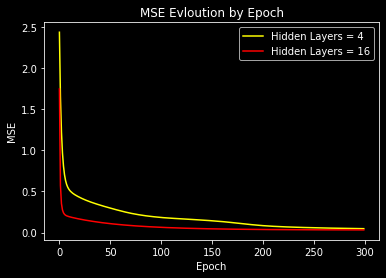

In [22]:
fig, ax = plt.subplots()
ax.plot(
    list(range(300)),
    [i.detach() for i in mses][:300],
    c='yellow',
    label='Hidden Layers = 4'
)
ax.plot(
    list(range(300)),
    [i.detach() for i in mses_old][:300],
    c='red',
    linestyle = '-',
    label='Hidden Layers = 16'
)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE Evloution by Epoch')
ax.legend()

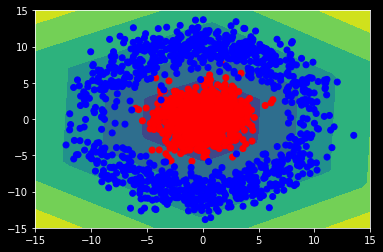

In [23]:
# decison boundary plot

X1, X2 = np.meshgrid(
    np.linspace(-15,15,num=50),
    np.linspace(-15,15,num=50)
)

X_mesh = torch.tensor(
    np.c_[X1.ravel(),X2.ravel()], 
    dtype=torch.float32
)
A1 = (
    torch.matmul(X_mesh, W1) + b1
).clamp(min=0)

A2 = torch.matmul(A1, W2) + b2

A2 = A2.squeeze().reshape(X1.shape).detach().numpy()

fig, ax = plt.subplots()
ax.contourf(X1, X2, A2)
ax.scatter(
    df_train['x1'], 
    df_train['x2'], 
    c=df_train['y'].map(
        {0:'red', 1:'blue'}
    )
)

## Set Up as Class<a class="anchor" id="section_3_1"></a>

In [24]:
class Net(nn.Module):
    def __init__(self, hidden_units, n_inputs, n_ouputs=1):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, hidden_units)
        self.fc2 = nn.Linear(hidden_units, n_outputs)
        
    def forward(self, x):
        x = self.fc1(x) #4 columns, 400 rows
        x = nn.functional.relu(x)
        x = self.fc2(x)
        
        return x

In [25]:
%%time

n_inputs = 2
hidden_units = 4
n_outputs = 1

mses = []

model = Net(hidden_units, n_inputs, n_outputs)

epochs = 20000
lr = 1e-2

for epoch in range(epochs):
    
    ### forward prop

    A2 = model(X) # this calls the forward method
    
    # loss
    mse = torch.mean((A2-y)**2)
    mses_old.append(mse)
    
    if (epoch % 1000) == 0:
        print(f'Epoch:\t{epoch}\tMSE:\t{round(mse.item(), 2)}')
        
    ### backward prop    
    model.zero_grad()    
            
    # find gradients
    mse.backward()
    
    
    with torch.no_grad():
    ### update parameters
    
        for param in model.parameters():
            param -= lr*param.grad

Epoch:	0	MSE:	2.16
Epoch:	1000	MSE:	0.03
Epoch:	2000	MSE:	0.03
Epoch:	3000	MSE:	0.03
Epoch:	4000	MSE:	0.03
Epoch:	5000	MSE:	0.03
Epoch:	6000	MSE:	0.03
Epoch:	7000	MSE:	0.03
Epoch:	8000	MSE:	0.03
Epoch:	9000	MSE:	0.03
Epoch:	10000	MSE:	0.03
Epoch:	11000	MSE:	0.03
Epoch:	12000	MSE:	0.03
Epoch:	13000	MSE:	0.03
Epoch:	14000	MSE:	0.03
Epoch:	15000	MSE:	0.03
Epoch:	16000	MSE:	0.03
Epoch:	17000	MSE:	0.03
Epoch:	18000	MSE:	0.03
Epoch:	19000	MSE:	0.03
CPU times: total: 2min 2s
Wall time: 31.1 s


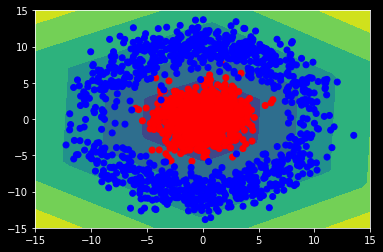

In [26]:
# decison boundary plot

X1, X2 = np.meshgrid(
    np.linspace(-15,15,num=50),
    np.linspace(-15,15,num=50)
)

X_mesh = torch.tensor(
    np.c_[X1.ravel(),X2.ravel()], 
    dtype=torch.float32
)
A1 = (
    torch.matmul(X_mesh, W1) + b1
).clamp(min=0)

A2 = torch.matmul(A1, W2) + b2

A2 = A2.squeeze().reshape(X1.shape).detach().numpy()

fig, ax = plt.subplots()
ax.contourf(X1, X2, A2)
ax.scatter(
    df_train['x1'], 
    df_train['x2'], 
    c=df_train['y'].map(
        {0:'red', 1:'blue'}
    )
)

## Optimiser<a class="anchor" id="section_3_2"></a>

In [27]:
%%time

mses = []

# create model with optimiser and criterion

model = Net(hidden_units, n_inputs, n_outputs)
optim = torch.optim.SGD(
    model.parameters(), 
    lr=lr
)
criteria = torch.nn.MSELoss()

for epoch in range(epochs):
    
    ### forward prop
    A2 = model(X) # this calls the forward method
    
    # loss
    mse = criteria(A2, y)
    mses_old.append(mse)
    
    if (epoch % 1000) == 0:
        print(f'Epoch:\t{epoch}\tMSE:\t{round(mse.item(), 2)}')
        
    ### backward prop    
    model.zero_grad()    
            
    # find gradients
    mse.backward()
    
    # update gradients
    
    optim.step()

Epoch:	0	MSE:	0.87
Epoch:	1000	MSE:	0.07
Epoch:	2000	MSE:	0.07
Epoch:	3000	MSE:	0.07
Epoch:	4000	MSE:	0.07
Epoch:	5000	MSE:	0.07
Epoch:	6000	MSE:	0.07
Epoch:	7000	MSE:	0.07
Epoch:	8000	MSE:	0.07
Epoch:	9000	MSE:	0.07
Epoch:	10000	MSE:	0.07
Epoch:	11000	MSE:	0.07
Epoch:	12000	MSE:	0.07
Epoch:	13000	MSE:	0.07
Epoch:	14000	MSE:	0.07
Epoch:	15000	MSE:	0.07
Epoch:	16000	MSE:	0.07
Epoch:	17000	MSE:	0.07
Epoch:	18000	MSE:	0.07
Epoch:	19000	MSE:	0.07
CPU times: total: 1min 30s
Wall time: 24.1 s


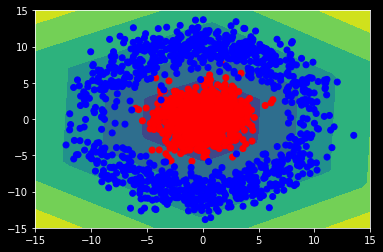

In [28]:
# decison boundary plot

X1, X2 = np.meshgrid(
    np.linspace(-15,15,num=50),
    np.linspace(-15,15,num=50)
)

X_mesh = torch.tensor(
    np.c_[X1.ravel(),X2.ravel()], 
    dtype=torch.float32
)
A1 = (
    torch.matmul(X_mesh, W1) + b1
).clamp(min=0)

A2 = torch.matmul(A1, W2) + b2

A2 = A2.squeeze().reshape(X1.shape).detach().numpy()

fig, ax = plt.subplots()
ax.contourf(X1, X2, A2)
ax.scatter(
    df_train['x1'], 
    df_train['x2'], 
    c=df_train['y'].map(
        {0:'red', 1:'blue'}
    )
)

## Working on GPU<a class="anchor" id="section_3_3"></a>

Make sure to check the setting up cuda note before this

In [29]:
torch.cuda.is_available()

True

In [30]:
# set device

torch.cuda.get_device_name(0) #need to install CUDA

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda', index=0)

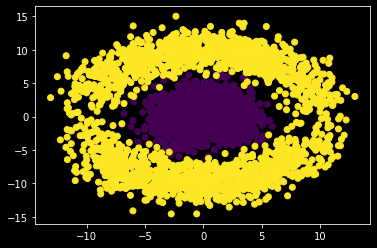

In [31]:
# data

N = 2000

df_train = deep_learning.ring.get_data(N=N)

fig, ax = plt.subplots()
ax.scatter(df_train['x1'], df_train['x2'], c=df_train['y'])

X = torch.tensor(df_train[['x1','x2']].values, dtype=torch.float32).to(device)
y = torch.tensor(df_train[['y']].values, dtype=torch.float32).to(device)

In [34]:
%%time

# fit 

# send model to device

model = Net(hidden_units, n_inputs, n_outputs).to(device)
optim = torch.optim.SGD(model.parameters(), lr=lr)
criteria = torch.nn.MSELoss()

for epoch in range(epochs):
    
    ### forward prop

    A2 = model(X) #this calls the forward method
    
    #loss    
    mse = criteria(A2, y)
    
    if (epoch % 1000) == 0:
        print(f'Epoch:\t{epoch}\tMSE:\t{round(mse.item(), 2)}')
        
    ### backward prop    
    model.zero_grad()    
            
    #find gradients
    mse.backward()
    
    #update gradients    
    optim.step()

Epoch:	0	MSE:	2.16
Epoch:	1000	MSE:	0.03
Epoch:	2000	MSE:	0.03
Epoch:	3000	MSE:	0.03
Epoch:	4000	MSE:	0.03
Epoch:	5000	MSE:	0.03
Epoch:	6000	MSE:	0.03
Epoch:	7000	MSE:	0.03
Epoch:	8000	MSE:	0.03
Epoch:	9000	MSE:	0.03
Epoch:	10000	MSE:	0.03
Epoch:	11000	MSE:	0.03
Epoch:	12000	MSE:	0.03
Epoch:	13000	MSE:	0.03
Epoch:	14000	MSE:	0.03
Epoch:	15000	MSE:	0.03
Epoch:	16000	MSE:	0.03
Epoch:	17000	MSE:	0.03
Epoch:	18000	MSE:	0.03
Epoch:	19000	MSE:	0.03
CPU times: total: 33 s
Wall time: 36.1 s


# 4. Dataloader<a class="anchor" id="chapter4"></a>

In [35]:
import sys
sys.path.append(os.path.join(os.path.abspath('.'), 'data'))
import deep_learning
import torch.nn as nn

In [36]:
# intro

data = [1,1,2,3,4,5,3,2,43,56,43,3,5,5,6,67,76,5,43,32]

loader = torch.utils.data.DataLoader(data, batch_size=3)

for data in loader:
    print(data)

tensor([1, 1, 2])
tensor([3, 4, 5])
tensor([ 3,  2, 43])
tensor([56, 43,  3])
tensor([5, 5, 6])
tensor([67, 76,  5])
tensor([43, 32])


In [37]:
# device

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

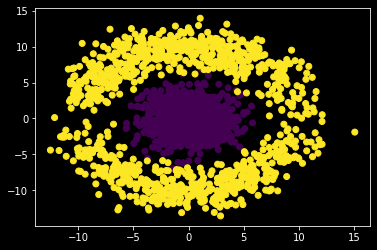

In [39]:
# data

N = 1000
df_train = deep_learning.ring.get_data(N=N)

fig, ax = plt.subplots()
ax.scatter(df_train['x1'], df_train['x2'], c=df_train['y'])

In [40]:
# dataloader

class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, data, device='cpu'):
        super().__init__()
        self.data = data
        self.device = device
        
    def __getitem__(self, index):
        x = torch.tensor(
            self.data.iloc[index][['x1','x2']], 
            dtype=torch.float32
        ).to(device)
        
        y = torch.tensor(
            self.data.iloc[index][['y']], 
            dtype=torch.float32
        ).to(device)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

batch_size = 8
trainset = MyDataset(df_train)
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=batch_size)

In [45]:
%%time

# fit

epochs = 200
model = Net(hidden_units, n_inputs, n_outputs).to(device)
optim = torch.optim.SGD(model.parameters(), lr=lr)
criteria = torch.nn.MSELoss()

for epoch in range(epochs):
    
    for X, y in trainloader:
        
        ### forward prop
        A2 = model(X)
        
        # loss
        mse = criteria(A2, y)
        
        ### backward prop    
        model.zero_grad()    
                
        # find gradients
        mse.backward()
        
        # update gradients
        optim.step()
    
    if (epoch % 20) == 0:
        print(f'Epoch:\t{epoch}\tMSE:\t{round(mse.item(), 2)}')

Epoch:	0	MSE:	0.07
Epoch:	20	MSE:	0.02
Epoch:	40	MSE:	0.03
Epoch:	60	MSE:	0.01
Epoch:	80	MSE:	0.01
Epoch:	100	MSE:	0.02
Epoch:	120	MSE:	0.03
Epoch:	140	MSE:	0.02
Epoch:	160	MSE:	0.05
Epoch:	180	MSE:	0.01
CPU times: total: 15min 20s
Wall time: 16min 16s


# 5. Ignite<a class="anchor" id="chapter5"></a>

In [50]:
import datetime as dt
import sys
sys.path.append(os.path.join(os.path.abspath('.'), 'data'))
import deep_learning
import torch.nn as nn

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import MeanSquaredError

In [51]:
# train network

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Net(hidden_units, n_inputs, n_outputs).to(device)
optim = torch.optim.SGD(model.parameters(), lr=lr)
criteria = torch.nn.MSELoss()

val_metrics = {'mse' : MeanSquaredError()}

trainer = create_supervised_trainer(
    model, optim, criteria, device=device
)
evaluator = create_supervised_evaluator(
    model, metrics=val_metrics, device=device
)

@trainer.on(Events.EPOCH_STARTED)
def print_time(trainer):
    print('Epoch number:', trainer.state.epoch)
    print('Start time  :', dt.datetime.now())
    
@trainer.on(Events.EPOCH_COMPLETED)
def print_results(trainer):
    evaluator.run(trainloader)
    metrics = evaluator.state.metrics
    print('Train MSE:', metrics['mse'])
    
trainer.run(trainloader, max_epochs=10)

Epoch number: 1
Start time  : 2022-05-21 20:28:40.227142
Train MSE: 0.03763685607910156
Epoch number: 2
Start time  : 2022-05-21 20:28:50.485792
Train MSE: 0.03232036209106445
Epoch number: 3
Start time  : 2022-05-21 20:29:01.162220
Train MSE: 0.03230910110473633
Epoch number: 4
Start time  : 2022-05-21 20:29:11.461196
Train MSE: 0.03134714126586914
Epoch number: 5
Start time  : 2022-05-21 20:29:20.166892
Train MSE: 0.03143977737426758
Epoch number: 6
Start time  : 2022-05-21 20:29:27.048984
Train MSE: 0.031814493179321286
Epoch number: 7
Start time  : 2022-05-21 20:29:33.810429
Train MSE: 0.03224393081665039
Epoch number: 8
Start time  : 2022-05-21 20:29:40.631598
Train MSE: 0.03348794555664063
Epoch number: 9
Start time  : 2022-05-21 20:29:48.607073
Train MSE: 0.03141367721557617
Epoch number: 10
Start time  : 2022-05-21 20:29:58.830935
Train MSE: 0.0314169864654541


State:
	iteration: 2500
	epoch: 10
	epoch_length: 250
	max_epochs: 10
	output: 0.03624845668673515
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

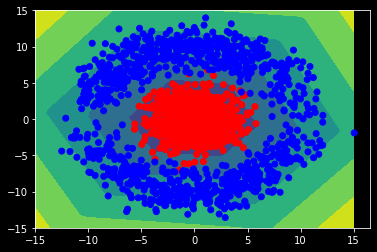

In [52]:
X1, X2 = np.meshgrid(
    np.linspace(-15,15,num=50),
    np.linspace(-15,15,num=50)
)

X_mesh = torch.tensor(
    np.c_[X1.ravel(), X2.ravel()], dtype=torch.float32
).to(device)
A2 = model(X_mesh)
A2 = A2.cpu().squeeze().reshape(X1.shape).detach().numpy()
 
fig, ax = plt.subplots()
ax.contourf(X1, X2, A2)
ax.scatter(
    df_train['x1'], 
    df_train['x2'], 
    c=df_train['y'].map({0:'red', 1:'blue'})
)


# 6. Tensorboard<a class="anchor" id="chapter6"></a>

In [56]:
import datetime as dt
import sys
sys.path.append(os.path.join(os.path.abspath('.'), 'data'))
import deep_learning
import torch.nn as nn

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import MeanSquaredError

from torch.utils.tensorboard import SummaryWriter

tensorboard_dir = os.path.join(os.path.abspath('.'), 'data', 'deep_learning_tensorboard')

In [57]:
# setup tensorboard

# We will use a summarywriter to log all our results

run_name = (
    'tensorboard_tutorial_' + 
    dt.datetime.now().strftime('%Y-%m-%d_%H%M')
)
log_dir = os.path.join(tensorboard_dir, run_name)
writer = SummaryWriter(log_dir)

In [58]:
# train network

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Net(hidden_units, n_inputs, n_outputs).to(device)
optim = torch.optim.SGD(model.parameters(), lr=lr)
criteria = torch.nn.MSELoss()

# logging to tensorboard

writer.add_text('Model description:', str(model))
writer.add_graph(
    model, 
    trainset[0][0].unsqueeze(0).to(device) # argument is an example of data 
) # gets computation graph


val_metrics = {'mse' : MeanSquaredError()}

trainer = create_supervised_trainer(
    model, optim, criteria, device=device
)
evaluator = create_supervised_evaluator(
    model, metrics=val_metrics, device=device
)

@trainer.on(Events.EPOCH_STARTED)
def print_time(trainer):
    print('Epoch number:', trainer.state.epoch)
    print('Start time  :', dt.datetime.now())
    
@trainer.on(Events.EPOCH_COMPLETED)
def print_results(trainer):
    evaluator.run(trainloader)
    metrics = evaluator.state.metrics
    print('Train MSE:', metrics['mse'])
    
trainer.run(trainloader, max_epochs=10)

CPU times: total: 0 ns
Wall time: 0 ns
Epoch number: 1
Start time  : 2022-05-21 20:39:37.894326
Train MSE: 0.03929119491577148
Epoch number: 2
Start time  : 2022-05-21 20:39:47.643304
Train MSE: 0.035847095489501955
Epoch number: 3
Start time  : 2022-05-21 20:39:57.413810
Train MSE: 0.03375423431396484
Epoch number: 4
Start time  : 2022-05-21 20:40:07.241523
Train MSE: 0.03402248764038086
Epoch number: 5
Start time  : 2022-05-21 20:40:16.998783
Train MSE: 0.03441543197631836
Epoch number: 6
Start time  : 2022-05-21 20:40:26.778747
Train MSE: 0.032683666229248044
Epoch number: 7
Start time  : 2022-05-21 20:40:36.420326
Train MSE: 0.03304265975952148
Epoch number: 8
Start time  : 2022-05-21 20:40:46.069073
Train MSE: 0.03396794128417969
Epoch number: 9
Start time  : 2022-05-21 20:40:55.638491
Train MSE: 0.03221029663085938
Epoch number: 10
Start time  : 2022-05-21 20:41:05.596777
Train MSE: 0.034671642303466796


State:
	iteration: 2500
	epoch: 10
	epoch_length: 250
	max_epochs: 10
	output: 0.029757829383015633
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [59]:
# plot

X1, X2 = np.meshgrid(np.linspace(-15,15,num=50),
                     np.linspace(-15,15,num=50))

X_mesh = torch.tensor(np.c_[X1.ravel(), X2.ravel()], dtype=torch.float32).to(device)
A2 = model(X_mesh)
A2 = A2.cpu().squeeze().reshape(X1.shape).detach().numpy()
 
fig, ax = plt.subplots()
ax.contourf(X1, X2, A2)
ax.scatter(df_train['x1'], df_train['x2'], c=df_train['y'].map({0:'red', 1:'blue'}))

writer.add_figure('Decision Boundary', fig) # write to tensorboard

## Model saving and loading<a class="anchor" id="section_6_1"></a>

In [60]:
# save
model_path = os.path.join(log_dir, 'model.pt')
torch.save(model.state_dict(),model_path)

In [61]:
# load
model_state_dict = torch.load(model_path)
print(model_state_dict)

OrderedDict([('fc1.weight', tensor([[-0.3393,  0.7270],
        [ 0.4593, -0.0854],
        [-0.1053,  0.0929],
        [-0.4199, -0.4660]], device='cuda:0')), ('fc1.bias', tensor([ 0.2574,  0.4672, -0.0608,  0.5855], device='cuda:0')), ('fc2.weight', tensor([[ 0.2097,  0.2497, -0.2160,  0.2006]], device='cuda:0')), ('fc2.bias', tensor([-0.4047], device='cuda:0'))])


In [63]:
# recreate NN
model_reload = Net(hidden_units, n_inputs, n_outputs)
print(model_reload.state_dict())

model_reload.load_state_dict(model_state_dict)
print(model_reload.state_dict())

OrderedDict([('fc1.weight', tensor([[ 0.4951, -0.2640],
        [-0.1531, -0.0309],
        [-0.3162, -0.0477],
        [ 0.0063,  0.3426]])), ('fc1.bias', tensor([ 0.5554,  0.2075, -0.5979,  0.3742])), ('fc2.weight', tensor([[ 0.2933, -0.1164, -0.0347,  0.3670]])), ('fc2.bias', tensor([-0.1519]))])
OrderedDict([('fc1.weight', tensor([[-0.3393,  0.7270],
        [ 0.4593, -0.0854],
        [-0.1053,  0.0929],
        [-0.4199, -0.4660]])), ('fc1.bias', tensor([ 0.2574,  0.4672, -0.0608,  0.5855])), ('fc2.weight', tensor([[ 0.2097,  0.2497, -0.2160,  0.2006]])), ('fc2.bias', tensor([-0.4047]))])


# 7. MNIST Data<a class="anchor" id="chapter7"></a>

In [140]:
import datetime as dt
import numpy as np
import os
import torch
import torch.nn as nn

import sys
sys.path.append(os.path.join(os.path.abspath('.'), 'data'))
import deep_learning

from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as f

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy

from sklearn.datasets import fetch_openml

In [89]:
class MyDataSet(torch.utils.data.Dataset):
    
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
 
    def __getitem__(self, index):
        return self.X[index], self.y[index]
 
    def __len__(self):
        return len(self.X)

In [100]:
class Net(nn.Module):
    
    def __init__(self, n_inputs, hidden_units_l1, hidden_units_l2, n_outputs):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, hidden_units_l1)
        self.fc2 = nn.Linear(hidden_units_l1, hidden_units_l2)
        self.fc3 = nn.Linear(hidden_units_l2, n_outputs)
        
    def forward(self, x):
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x) 
        # we will apply softmax outside the function instead of here
        
        return x

In [101]:
# tensorboard setup

run_name = 'tensorboard_MNIST_' + dt.datetime.now().strftime('%Y-%m-%d_%H%M')
log_dir = os.path.join(tensorboard_dir, run_name)
writer = SummaryWriter(log_dir)

In [93]:
%%time

# data

X_raw, y_raw = fetch_openml('mnist_784', version=1, return_X_y=True)
X = torch.tensor(X_raw.values, dtype=torch.float32).to(device)
y = torch.tensor(y_raw.astype(float)).type(torch.FloatTensor).to(device)

CPU times: total: 2min 38s
Wall time: 2min 37s


In [134]:
N = 60000
batch_size = 8

trainset = MyDataSet(X[:N], y[:N])
validset = MyDataSet(X[N:], y[N:])
trainloader = torch.utils.data.DataLoader(
    trainset, shuffle=True, batch_size=batch_size
)
validloader = torch.utils.data.DataLoader(
    validset, shuffle=True, batch_size=batch_size
)

In [135]:
# 2 hidden layers, 128 units and 64 units respectively

n_inputs = 28*28
hidden_units_l1 = 128
hidden_units_l2 = 64
n_outputs = 8

epochs = 10
lr = 1e-4

model = Net(n_inputs, hidden_units_l1, hidden_units_l2, n_outputs).to(device)
optim = torch.optim.SGD(model.parameters(), lr=lr)
criteria = torch.nn.MSELoss()

writer.add_text('Model description:', str(model))
writer.add_graph(model, trainset[0][0].unsqueeze(0).to(device))

In [136]:
# train network

val_metrics = {'Accuracy' : Accuracy()}

trainer   = create_supervised_trainer(
    model, optim, criteria, device=device
)
evaluator = create_supervised_evaluator(
    model, metrics=val_metrics, device=device
)

@trainer.on(Events.EPOCH_STARTED)
def print_time(trainer):
    print('Start time  :', dt.datetime.now())
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(trainloader)
    metrics = evaluator.state.metrics
    epoch_no = trainer.state.epoch
    print('Train Accuracy:', metrics['Accuracy'])
    writer.add_scalar('Accuracy (Train)', metrics['Accuracy'], epoch_no)
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(validloader)
    metrics = evaluator.state.metrics
    epoch_no = trainer.state.epoch
    print('Validation Accuracy: ', metrics['Accuracy'])
    writer.add_scalar('Accuracy (validation)', metrics['Accuracy'], epoch_no)
    
trainer.run(trainloader, max_epochs=epochs)

Start time  : 2022-05-21 21:29:35.747688
Train Accuracy: 0.10423333333333333
Validation Accuracy:  0.1034
Start time  : 2022-05-21 21:30:17.385893
Train Accuracy: 0.0982
Validation Accuracy:  0.1032
Start time  : 2022-05-21 21:30:58.626689
Train Accuracy: 0.10736666666666667
Validation Accuracy:  0.1104
Start time  : 2022-05-21 21:31:39.752689
Train Accuracy: 0.08546666666666666
Validation Accuracy:  0.082
Start time  : 2022-05-21 21:32:21.416690
Train Accuracy: 0.09926666666666667
Validation Accuracy:  0.0973
Start time  : 2022-05-21 21:33:02.405763
Train Accuracy: 0.09941666666666667
Validation Accuracy:  0.0984
Start time  : 2022-05-21 21:33:43.805995
Train Accuracy: 0.09586666666666667
Validation Accuracy:  0.0928
Start time  : 2022-05-21 21:34:06.449242
Train Accuracy: 0.09866666666666667
Validation Accuracy:  0.0952
Start time  : 2022-05-21 21:34:30.257285
Train Accuracy: 0.076
Validation Accuracy:  0.079
Start time  : 2022-05-21 21:35:12.600231
Train Accuracy: 0.1115833333333333

State:
	iteration: 75000
	epoch: 10
	epoch_length: 7500
	max_epochs: 10
	output: 10.602726936340332
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [137]:
model_path = os.path.join(log_dir, 'model.pt')
torch.save(model.state_dict(),model_path)

# 8. Optimisation<a class="anchor" id="chapter8"></a>

A script showing how to implement a neural network step by step.
Improves on the previous example by utilizing:
- automatic differentiation
- the torch.nn module
- built-in optimizer
- built-in loss function
- GPU training
- a dataloader
- PyTorch ignite
- Tensorboard
- Model saving
- Learning rate finder
- Adam optimizer
- Regularisation through weight decay

In [3]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
from torch_lr_finder import LRFinder

import sys
sys.path.append(os.path.join(os.path.abspath('.'), 'data'))
import deep_learning

from torch.utils.tensorboard import SummaryWriter

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import MeanSquaredError

In [5]:
# setup tensorboard

tensorboard_dir = os.path.join(os.path.abspath('.'), 'data', 'deep_learning_tensorboard')
run_name = 'tensorboard_optim_' + dt.datetime.now().strftime('%Y-%m-%d_%H%M')
log_dir = os.path.join(tensorboard_dir, run_name)
writer = SummaryWriter(log_dir)

In [6]:
# device

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
# data

N = 200

df_train = deep_learning.ring.get_data(N=N)
df_valid = deep_learning.ring.get_data(N=N)

fig, ax = plt.subplots()
ax.scatter(df_train['x1'], df_train['x2'], c=df_train['y'])

# write image to tensorboard
writer.add_figure('Training data', fig)

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, device='cpu'):
        
        super().__init__()
        self.data   = data
        self.device = device
        
    def __getitem__(self, index):
        
        x = torch.tensor(
            self.data.iloc[index][['x1','x2']], 
            dtype=torch.float32
        ).to(device)
        
        y = torch.tensor(
            self.data.iloc[index][['y']], 
            dtype=torch.float32
        ).to(device)
        
        return x, y
    
    def __len__(self):
        return len(self.data)
    

batch_size  = 8
trainset = MyDataset(df_train, device)
validset = MyDataset(df_valid, device)
trainloader = torch.utils.data.DataLoader(
    trainset, shuffle=True, batch_size=batch_size
)
validloader = torch.utils.data.DataLoader(
    validset, shuffle=True, batch_size=batch_size
)

In [8]:
# fit network

n_inputs = 2
hidden_units = 4
n_outputs = 1
epochs = 200
lr = 1e-6

class Net(nn.Module):
    def __init__(self, hidden_units, n_inputs, n_outputs):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, hidden_units)
        self.fc2 = nn.Linear(hidden_units, n_outputs)
        
    def forward(self, x):
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        
        return x
    
model = Net(hidden_units, n_inputs, n_outputs).to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
criteria = torch.nn.MSELoss()

writer.add_text('Model description:', str(model))
writer.add_graph(model, trainset[0][0].unsqueeze(0).to(device))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [00:23<00:00, 42.35it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.12E-06


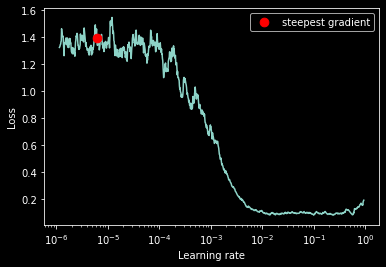

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 6.120498372476698e-06)

In [12]:
# learning rate finder

lr_finder = LRFinder(model, optim, criteria)
lr_finder.range_test(trainloader, end_lr=1, num_iter=1000)
lr_finder.plot()

In [13]:
print(lr_finder.optimizer)

lr_finder.reset()
optim = lr_finder.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 1e-06
    lr: 1.0139254075588162
    maximize: False
    weight_decay: 0.01
)


In [14]:
# train network

val_metrics = {'mse' : MeanSquaredError()}

trainer   = create_supervised_trainer(
    model, optim, criteria, device=device
)
evaluator = create_supervised_evaluator(
    model, metrics=val_metrics, device=device
)

@trainer.on(Events.EPOCH_STARTED)
def print_time(trainer):
    #print('Epoch number:', trainer.state.epoch)
    print('Start time  :', dt.datetime.now())
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(trainloader)
    metrics = evaluator.state.metrics
    epoch_no = trainer.state.epoch
    print('Train MSE:', metrics['mse'])
    writer.add_scalar('MSE (Train)', metrics['mse'], epoch_no)
    
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(validloader)
    metrics = evaluator.state.metrics
    epoch_no = trainer.state.epoch
    print('Validation MSE: ', metrics['mse'])
    writer.add_scalar('MSE (validation)', metrics['mse'], epoch_no)
    
trainer.run(trainloader, max_epochs=10)

Start time  : 2022-05-24 18:57:37.167270
Train MSE: 1.3676553344726563
Validation MSE:  1.5332563781738282
Start time  : 2022-05-24 18:57:40.269623
Train MSE: 1.3667236328125
Validation MSE:  1.53221923828125
Start time  : 2022-05-24 18:57:43.019571
Train MSE: 1.365830078125
Validation MSE:  1.5312210083007813
Start time  : 2022-05-24 18:57:45.737130
Train MSE: 1.364922332763672
Validation MSE:  1.530215301513672
Start time  : 2022-05-24 18:57:48.487008
Train MSE: 1.3639776611328125
Validation MSE:  1.5291650390625
Start time  : 2022-05-24 18:57:51.337013
Train MSE: 1.3630455017089844
Validation MSE:  1.52812744140625
Start time  : 2022-05-24 18:57:54.024762
Train MSE: 1.362147979736328
Validation MSE:  1.5271281433105468
Start time  : 2022-05-24 18:57:56.666267
Train MSE: 1.361210174560547
Validation MSE:  1.5260836791992187
Start time  : 2022-05-24 18:57:59.487448
Train MSE: 1.3603158569335938
Validation MSE:  1.52508544921875
Start time  : 2022-05-24 18:58:02.392449
Train MSE: 1.359

State:
	iteration: 500
	epoch: 10
	epoch_length: 50
	max_epochs: 10
	output: 3.0135419368743896
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

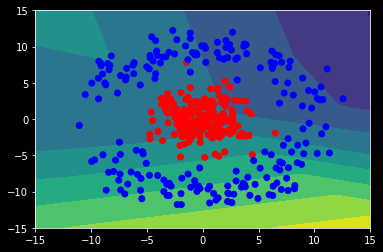

In [15]:
X1, X2 = np.meshgrid(np.linspace(-15,15,num=50),
                     np.linspace(-15,15,num=50))

X_mesh = torch.tensor(np.c_[X1.ravel(), X2.ravel()], dtype=torch.float32).to(device)
A2 = model(X_mesh)
A2 = A2.cpu().squeeze().reshape(X1.shape).detach().numpy()
 
fig, ax = plt.subplots()
ax.contourf(X1, X2, A2)
ax.scatter(df_train['x1'], df_train['x2'], c=df_train['y'].map({0:'red', 1:'blue'}))

In [16]:
writer.add_figure('Decision Boundary', fig)

In [17]:
# save
model_path = os.path.join(log_dir, 'model.pt')
torch.save(model.state_dict(),model_path)

# load
model_state_dict = torch.load(model_path)
print(model_state_dict)

OrderedDict([('fc1.weight', tensor([[ 0.2057,  0.6274],
        [ 0.0780, -0.6534],
        [ 0.6083,  0.6621],
        [ 0.2943, -0.3559]], device='cuda:0')), ('fc1.bias', tensor([-0.1443,  0.1899, -0.3291,  0.6925], device='cuda:0')), ('fc2.weight', tensor([[ 0.2495,  0.3996, -0.2847,  0.0773]], device='cuda:0')), ('fc2.bias', tensor([0.2062], device='cuda:0'))])


In [18]:
#recreate NN
model_reload = Net(hidden_units, n_inputs, n_outputs)
print(model_reload.state_dict())

model_reload.load_state_dict(model_state_dict)
print(model_reload.state_dict())

OrderedDict([('fc1.weight', tensor([[-0.6181,  0.1754],
        [ 0.2796,  0.4984],
        [ 0.2925,  0.1004],
        [-0.6689, -0.0442]])), ('fc1.bias', tensor([ 0.1924, -0.3997,  0.5877, -0.2444])), ('fc2.weight', tensor([[ 0.3271,  0.1674,  0.2860, -0.4361]])), ('fc2.bias', tensor([0.1128]))])
OrderedDict([('fc1.weight', tensor([[ 0.2057,  0.6274],
        [ 0.0780, -0.6534],
        [ 0.6083,  0.6621],
        [ 0.2943, -0.3559]])), ('fc1.bias', tensor([-0.1443,  0.1899, -0.3291,  0.6925])), ('fc2.weight', tensor([[ 0.2495,  0.3996, -0.2847,  0.0773]])), ('fc2.bias', tensor([0.2062]))])
